# Machine Learning - TP2: Detectando lugares del mundo

### Dependencias

In [7]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

import matplotlib.pyplot as plt
# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import VGG16, MobileNetV2, EfficientNetB7, InceptionResNetV2
from tensorflow.keras.optimizers import Adam


### Origen de datos

En sí contamos con train y test, pero para poder analizar el resultado del entrenamiento, tomamos el 20% de las imágenes de train de forma aleatoria para crear un directorio de validation (el script utilizado se encuentra en la raíz del repositorio como create_validation.py)

In [8]:
# Fede: /media/federico/secondary/Repositorios/UCSE/MachineLearning/data_tp2/
# Andy: C:/Users/andru/Downloads/ucse-ia-2024-tp-2-clasificacion-de-imagenes/
# Facu: /home/facu/data_tp2/
BASE_DIR = '/home/facu/data_tp2/'

TRAIN_DIR = Path(BASE_DIR + 'train')
VALIDATION_DIR = Path(BASE_DIR + 'validation')
TEST_DIR = Path(BASE_DIR + 'test')

### Variables Globales

In [9]:
CLASES = "street", "sea", "mountain", "glacier", "forest", "buildings"

#### Parámetros a probar

In [10]:
# Las primeras pruebas las vamos a realizar empleando un size un poco más chico en las imagenes.
SIZE = 64
BIGGER_SIZE = 150

### Leer imágenes de entrada

In [11]:
images_reader = ImageDataGenerator(
    rescale=1/255, #para que el valor del pixel vaya entre 0 y 1
    rotation_range=10,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    #horizontal_flip=True,
    #vertical_flip=True,
)

READ_PARAMS = dict(
    class_mode="categorical",
    classes=CLASES,
    target_size=(SIZE, SIZE),
    color_mode="rgb",
)
READ_PARAMS_BIGGER = dict(
    class_mode="categorical",
    classes=CLASES,
    target_size=(BIGGER_SIZE, BIGGER_SIZE),
    color_mode="rgb",
)

In [12]:
train = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS)
validation = images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS)

train_bigger = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS_BIGGER)
validation_bigger = images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS_BIGGER)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


Definimos una función para mostrar ejemplos de imagenes del dataset

In [13]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(CLASES[np.argmax(labels[i])])
        plt.axis("off")

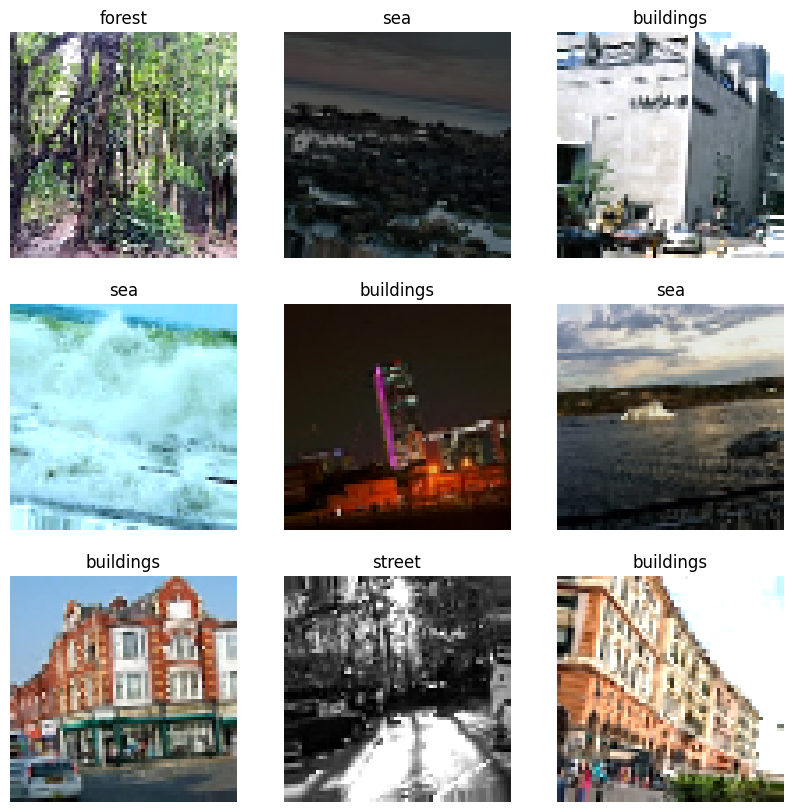

In [14]:
sample_images(train)

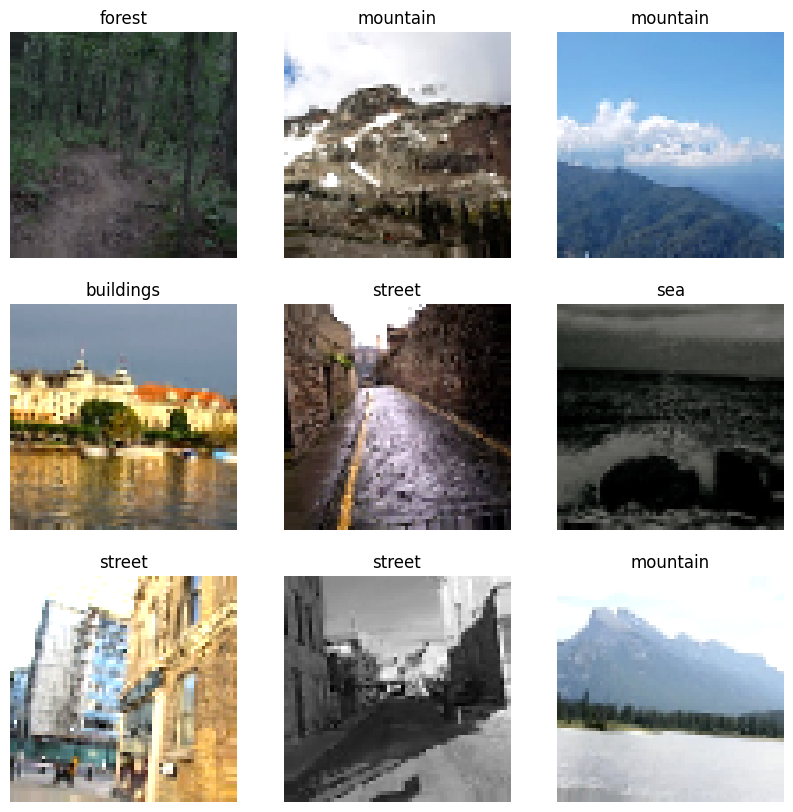

In [15]:
sample_images(validation)

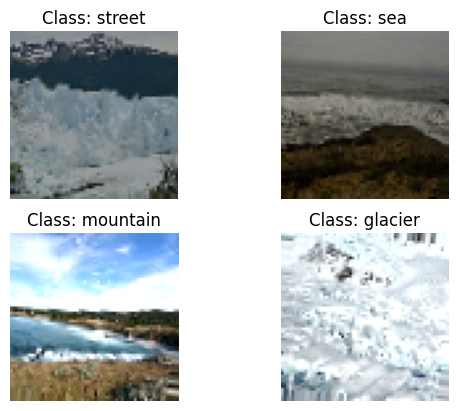

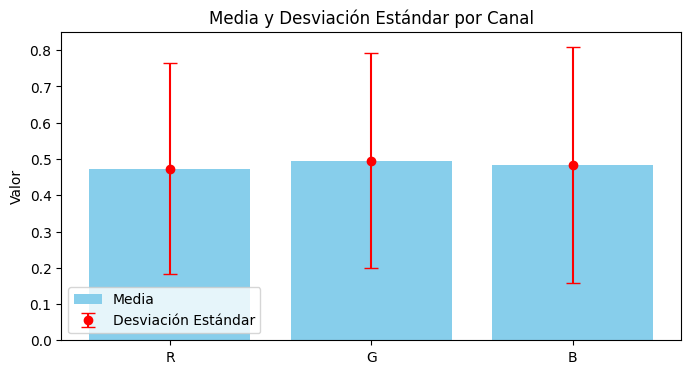

In [16]:
for x_batch, y_batch in train:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Class: {CLASES[i]}")
        plt.axis('off')
    plt.show()

    mean = np.mean(x_batch, axis=(0, 1, 2))
    std = np.std(x_batch, axis=(0, 1, 2))

    plt.figure(figsize=(8, 4))
    channels = ['R', 'G', 'B']
    
    plt.bar(channels, mean, color='skyblue', label='Media')
    plt.errorbar(channels, mean, yerr=std, fmt='o', color='red', label='Desviación Estándar', capsize=5)
    plt.ylabel("Valor")
    plt.title("Media y Desviación Estándar por Canal")
    plt.legend()
    plt.show()
    break

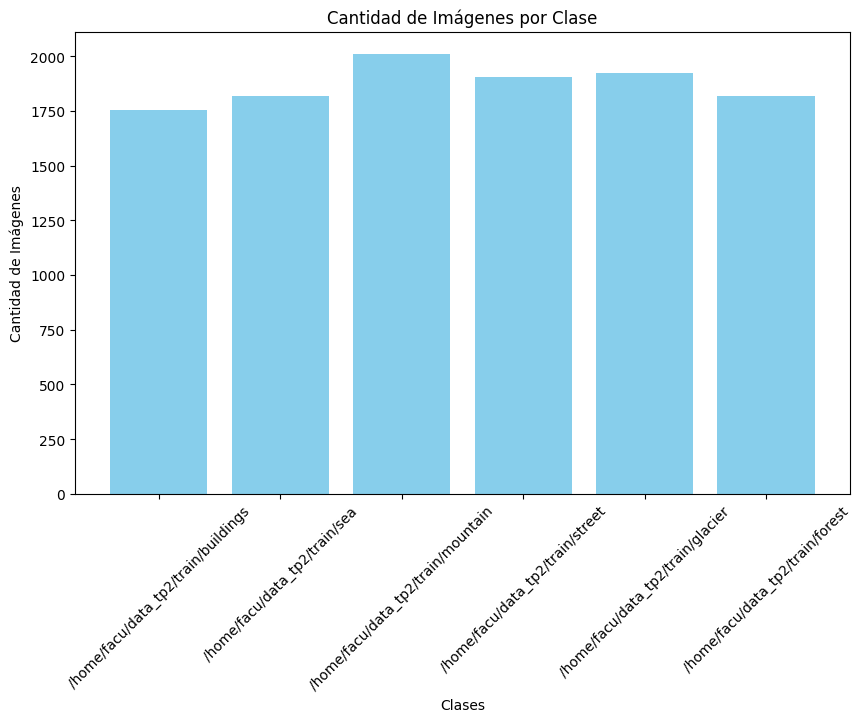

In [17]:
contador_imagenes = {}
for subcarpeta, _, _ in os.walk(TRAIN_DIR):
    imagenes = tf.io.gfile.glob(os.path.join(subcarpeta, "*.jpg"))
    contador_imagenes[subcarpeta] = len(imagenes)

clasesplt = []
cantidades = []

for clase, cantidad in contador_imagenes.items():
        partes = clase.split('\\')
        clases = partes[-1].split(".")[0]      
        clasesplt.append(clases)
        cantidades.append(cantidad)

clasesplt.pop(0)
cantidades.pop(0)
plt.figure(figsize=(10, 6))
plt.bar(clasesplt, cantidades, color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Cantidad de Imágenes')
plt.title('Cantidad de Imágenes por Clase')
plt.xticks(rotation=45)
plt.show()

# Modelado de Redes Neuronales

In [18]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (SIZE, SIZE, 3)
input_shape

bigger_input_shape= (BIGGER_SIZE, BIGGER_SIZE, 3)
bigger_input_shape

(150, 150, 3)

## MLP

In [15]:
mlp = Sequential([
    Input(input_shape),
    
    Flatten(),

    Dense(500, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CLASES), activation='softmax'),
])

I0000 00:00:1730914816.620255   39369 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [16]:
mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [17]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     6,144,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,147,506 (23.45 MB)

 Trainable params: 6,147,506 (23.45 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamos la red, pero por una cuestión teórica, ya suponemos que este tipo de redes no es óptima para problemas de imágenes

Los resultados son un desastre, está underfitteando. En la primer etapa da casi la misma medición de accuracy que en la quinta

## Red Convolucional

Al principio probamos con los parámetros tal cual están en el notebook de ejemplo de la materia, teniendo una accuracy en validation de 0.67 y de 0.68 en train

In [18]:
convolutional = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CLASES), activation='softmax'),
])

In [19]:
convolutional.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [20]:
convolutional.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 61, 61, 10)     │           490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61, 61, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 10)     │         1,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 58, 58, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       196,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,806 (776.59 KB)

 Trainable params: 198,806 (776.59 KB)

 Non-trainable params: 0 (0.00 B)

Agregamos algunas mejoras:
- Más cantidad de filtros, y los vamos aumentando con cada capa
- Reducimos el kernel para que sea más chico y encuentre detalles más finos
- Aumentamos el dropout para compensar el overfitting que podría sumar el aumentar los filtros y reducir el kernel
- Cambiamos el método de pooling de Flatten a GlobalAveragePooling2D (por lo que investigamos anda mejor con imágenes)
- Incrementamos la cantidad de neuronas (puede aportar también al overfitting)
- Usamos relu en lugar de tanh como función de activación en la capa Densa antes de la salida
- Agregamos BatchNormalization entre cada capa

### Segunda red convolucional:

In [21]:
convolutional2 = Sequential([
    Input(shape=input_shape),

    Convolution2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Convolution2D(filters=64, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Convolution2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(CLASES), activation='softmax'),
])
#Con mayor resolución:
convolutional2_bigger = Sequential([
    Input(shape=bigger_input_shape),

    Convolution2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Convolution2D(filters=64, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Convolution2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(CLASES), activation='softmax'),
])

In [22]:
convolutional2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [23]:
convolutional2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,734 (506.77 KB)

 Trainable params: 128,774 (503.02 KB)

 Non-trainable params: 960 (3.75 KB)

In [24]:
#Mas grandeeeeeeeee
convolutional2_bigger.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [25]:
convolutional2_bigger.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 146, 146, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 71, 71, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,734 (506.77 KB)

 Trainable params: 128,774 (503.02 KB)

 Non-trainable params: 960 (3.75 KB)

## Tercera red

In [26]:
#Este es un modelo que encontre en internet
convolutional3 = Sequential([
    Input(shape=input_shape),
    Convolution2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Convolution2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Convolution2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Convolution2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(len(CLASES), activation='softmax')
])

In [27]:
convolutional3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)


In [28]:
convolutional3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,473,862 (5.62 MB)

 Trainable params: 1,472,390 (5.62 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [29]:
#Intentamos con un dropout más bajo en un modelo de muchas capas.
convolutional4 = Sequential([
    Input(shape=input_shape),

    Convolution2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Convolution2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Convolution2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Convolution2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Convolution2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(CLASES), activation='softmax'),
])
#Mas grande
#Intentamos con un dropout más bajo en un modelo de muchas capas.
convolutional4_bigger = Sequential([
    Input(shape=bigger_input_shape),

    Convolution2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Convolution2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Convolution2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Convolution2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Convolution2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(CLASES), activation='softmax'),
])

In [30]:
convolutional4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [31]:
convolutional4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,65

 Total params: 1,840,326 (7.02 MB)

 Trainable params: 1,837,318 (7.01 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [32]:
#Mas grande
convolutional4_bigger.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [33]:
#Mas grande
convolutional4_bigger.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 9, 9, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 9, 9, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,65

 Total params: 1,840,326 (7.02 MB)

 Trainable params: 1,837,318 (7.01 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [34]:
#Ahora intentamos con un modelo profundo con mayor dropout, evitando overfitting
convolutional5 = Sequential([
    Input(shape=input_shape),

    Convolution2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Convolution2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Convolution2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Convolution2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Convolution2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(CLASES), activation='softmax'),
])

#Mas grande
convolutional5_bigger = Sequential([
    Input(shape=bigger_input_shape),

    Convolution2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Convolution2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Convolution2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Convolution2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Convolution2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(CLASES), activation='softmax'),
])

In [35]:
convolutional5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [36]:
convolutional5.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       262,65

 Total params: 1,840,326 (7.02 MB)

 Trainable params: 1,837,318 (7.01 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [37]:
#Y mas grande?  Mas grandeeeeeeeeeee
convolutional5_bigger.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

### Entrenamiento

## Modelo 2:

In [38]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [39]:
history = convolutional2.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

Epoch 1/5


/home/facu/UCSE-2024-ML-TP2/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730914820.845518   39657 service.cc:148] XLA service 0x7fbbb00072a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730914820.845574   39657 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1730914821.209031   39657 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/351 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.1790 - loss: 2.5749

I0000 00:00:1730914826.297588   39657 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.4343 - loss: 1.6471 - val_accuracy: 0.2165 - val_loss: 3.3204
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.6066 - loss: 1.0403 - val_accuracy: 0.5321 - val_loss: 1.3555
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.6710 - loss: 0.8815 - val_accuracy: 0.5663 - val_loss: 1.2356
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.7229 - loss: 0.7489 - val_accuracy: 0.7197 - val_loss: 0.7274
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.7433 - loss: 0.6939 - val_accuracy: 0.4918 - val_loss: 1.4043


## Modelo 2 mas grande:

In [40]:
history = convolutional2_bigger.fit(
    train_bigger,
    epochs=5,
    batch_size=128,
    validation_data=validation_bigger,
    callbacks=[OurCustomCallback()]
)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 168ms/step - accuracy: 0.4240 - loss: 1.6400 - val_accuracy: 0.2311 - val_loss: 2.8463
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.6036 - loss: 1.0263 - val_accuracy: 0.4968 - val_loss: 1.4011
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - accuracy: 0.6778 - loss: 0.8459 - val_accuracy: 0.3659 - val_loss: 1.9706
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 142ms/step - accuracy: 0.6992 - loss: 0.7806 - val_accuracy: 0.6790 - val_loss: 0.8642
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 138ms/step - accuracy: 0.7395 - loss: 0.7054 - val_accuracy: 0.5007 - val_loss: 1.7937


## Modelo 3:

In [71]:
history = convolutional3.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.5098 - loss: 1.3621 - val_accuracy: 0.3288 - val_loss: 1.6978
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.7058 - loss: 0.8111 - val_accuracy: 0.7054 - val_loss: 0.8734
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.7489 - loss: 0.7146 - val_accuracy: 0.7086 - val_loss: 0.8028
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.7863 - loss: 0.6023 - val_accuracy: 0.7068 - val_loss: 0.8468
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8064 - loss: 0.5391 - val_accuracy: 0.7343 - val_loss: 0.7531


## Modelo 4:

In [41]:
history = convolutional4.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - accuracy: 0.4944 - loss: 1.4633 - val_accuracy: 0.3327 - val_loss: 2.6565
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.6848 - loss: 0.8830 - val_accuracy: 0.5435 - val_loss: 1.4422
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.7461 - loss: 0.7104 - val_accuracy: 0.7746 - val_loss: 0.6398
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.7714 - loss: 0.6339 - val_accuracy: 0.7079 - val_loss: 0.7795
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.7938 - loss: 0.5893 - val_accuracy: 0.7175 - val_loss: 0.7914


## Modelo 4 mas grande:

In [42]:
history = convolutional4_bigger.fit(
    train_bigger,
    epochs=5,
    batch_size=128,
    validation_data=validation_bigger,
    callbacks=[OurCustomCallback()]
)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 168ms/step - accuracy: 0.5095 - loss: 1.4000 - val_accuracy: 0.2090 - val_loss: 3.1814
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 146ms/step - accuracy: 0.6909 - loss: 0.8224 - val_accuracy: 0.5802 - val_loss: 1.1560
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - accuracy: 0.7648 - loss: 0.6432 - val_accuracy: 0.6837 - val_loss: 1.1337
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - accuracy: 0.7895 - loss: 0.5923 - val_accuracy: 0.6031 - val_loss: 1.2477
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - accuracy: 0.8162 - loss: 0.5114 - val_accuracy: 0.8014 - val_loss: 0.5290


## Modelo 5

In [43]:
history = convolutional5.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 34s 71ms/step - accuracy: 0.4036 - loss: 1.8832 - val_accuracy: 0.4308 - val_loss: 1.7316
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.6344 - loss: 1.0050 - val_accuracy: 0.5621 - val_loss: 1.2313
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.7015 - loss: 0.8109 - val_accuracy: 0.7111 - val_loss: 0.8216
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.7365 - loss: 0.7276 - val_accuracy: 0.6355 - val_loss: 1.0602
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.7646 - loss: 0.6634 - val_accuracy: 0.5749 - val_loss: 1.4299


## Modelo 5 mas grande

In [44]:
history = convolutional5_bigger.fit(
    train_bigger,
    epochs=5,
    batch_size=128,
    validation_data=validation_bigger,
    callbacks=[OurCustomCallback()]
)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 67s 160ms/step - accuracy: 0.4325 - loss: 1.7372 - val_accuracy: 0.2222 - val_loss: 3.2674
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - accuracy: 0.6582 - loss: 0.9534 - val_accuracy: 0.4772 - val_loss: 3.2172
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - accuracy: 0.7274 - loss: 0.7422 - val_accuracy: 0.7211 - val_loss: 0.8082
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step - accuracy: 0.7771 - loss: 0.6367 - val_accuracy: 0.5478 - val_loss: 1.3543
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 141ms/step - accuracy: 0.7977 - loss: 0.5696 - val_accuracy: 0.5738 - val_loss: 1.5164


# Transfer Learning

Para los modelos empleados en Transfer Learning vamos a emplear solamente el tamaño 150x150

## VGG16

In [45]:
# Convolucional usando convoluciones ya entrenadas de VGG16
pretrained_model = VGG16(input_shape=bigger_input_shape, include_top=False)
pretrained_model.trainable = False

model_vgg16 = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(CLASES), activation='softmax'),
])

In [46]:
model_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [47]:
model_vgg16.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 100)            │       819,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,544,694 (59.30 MB)

 Trainable params: 830,006 (3.17 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

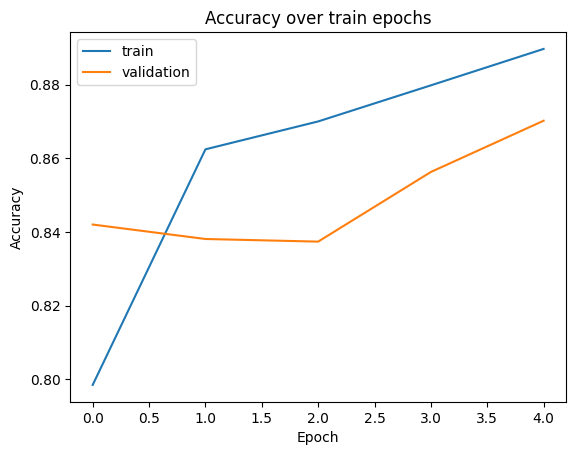

In [50]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## MobileNetV2

Usamos este modelo pre-entrenado porque vimos que consumía pocos recursos, y ya que no tenemos placa gráfica, puede ahorrarnos tiempo

In [51]:
# Cargamos MobileNetV2, sin la capa superior (clasificación) y la congelamos
base_model = MobileNetV2(
    weights='imagenet',      # Usamos pesos preentrenados en ImageNet
    include_top=False,       # Excluimos la capa de clasificación original
    input_shape=bigger_input_shape
)
base_model.trainable = False

# Construimos el modelo agregando capas personalizadas encima del modelo base
model_mobilenetv2 = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),  # Capa densa personalizada para procesar las características
    Dropout(0.5),                   # Dropout para regularización
    Dense(len(CLASES), activation='softmax')  # Capa de salida con softmax para clasificación multi-clase
])

# Compilamos el modelo
model_mobilenetv2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/tmp/ipykernel_39369/3954561241.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [52]:
# Entrenamos solo las capas personalizadas con el modelo base congelado
history = model_mobilenetv2.fit(
    train_bigger,
    batch_size=16,
    validation_data=validation_bigger,
    epochs=10,
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 69s 177ms/step - accuracy: 0.6162 - loss: 2.1831 - val_accuracy: 0.8606 - val_loss: 0.3941
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 141ms/step - accuracy: 0.7257 - loss: 0.6749 - val_accuracy: 0.8855 - val_loss: 0.3580
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - accuracy: 0.7658 - loss: 0.5879 - val_accuracy: 0.8823 - val_loss: 0.3862
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 141ms/step - accuracy: 0.7718 - loss: 0.5670 - val_accuracy: 0.8873 - val_loss: 0.3723
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - accuracy: 0.8001 - loss: 0.5056 - val_accuracy: 0.8837 - val_loss: 0.3281
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - accuracy: 0.8003 - loss: 0.5056 - val_accuracy: 0.8905 - val_loss: 0.3164
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.8074 - loss: 0.4770 - val_accuracy: 0.8951 - val_loss: 0.3529
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - accuracy: 0.8209 - loss: 0

## InceptionResNetV2

In [20]:
inception_model = InceptionResNetV2(input_shape=bigger_input_shape, include_top=False, weights='imagenet')
inception_model.trainable = False  # Congela las capas preentrenadas

# Crear el modelo completo usando Sequential
model = Sequential([
    inception_model,               # Modelo base de Inception-ResNetV2
    GlobalAveragePooling2D(),      
    Dense(512, activation='relu'),
    Dropout(0.5),                  # Dropout para reducir el overfitting
    Dense(len(CLASES), activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1730943544.909167   57255 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 3, 3, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,126,758 (210.29 MB)

 Trainable params: 790,022 (3.01 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [24]:
history = model.fit(
    train_bigger,
    batch_size=16,
    validation_data=validation_bigger,
    epochs=5,
    callbacks=[OurCustomCallback()]
)

/home/facu/UCSE-2024-ML-TP2/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 117s 264ms/step - accuracy: 0.6985 - loss: 0.8869 - val_accuracy: 0.8773 - val_loss: 0.3443
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step - accuracy: 0.8605 - loss: 0.3902 - val_accuracy: 0.8827 - val_loss: 0.3030
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 142ms/step - accuracy: 0.8791 - loss: 0.3353 - val_accuracy: 0.8927 - val_loss: 0.2842
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 146ms/step - accuracy: 0.8903 - loss: 0.3235 - val_accuracy: 0.8887 - val_loss: 0.2896
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 148ms/step - accuracy: 0.8832 - loss: 0.3054 - val_accuracy: 0.8948 - val_loss: 0.2758


## InceptionResNetV2 con modificaciones y nuevas imágenes

Primero leemos las imagenes nuevamente, pero cambiando algunos parámetros

In [32]:
images_reader_2 = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    zoom_range=0.2,
)

train_bigger_modificado = images_reader_2.flow_from_directory(TRAIN_DIR, **READ_PARAMS_BIGGER)
validation_bigger_modificado = images_reader_2.flow_from_directory(VALIDATION_DIR, **READ_PARAMS_BIGGER)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [35]:
inception_model_2 = InceptionResNetV2(input_shape=bigger_input_shape, include_top=False, weights='imagenet')
inception_model_2.trainable = False  # Congela las capas preentrenadas

model = Sequential([
    inception_model_2,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASES), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento inicial con el modelo base congelado
initial_history = model.fit(
    train_bigger_modificado,
    validation_data=validation_bigger_modificado,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 102s 242ms/step - accuracy: 0.6737 - loss: 0.9280 - val_accuracy: 0.8477 - val_loss: 0.4095
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 196ms/step - accuracy: 0.8344 - loss: 0.4634 - val_accuracy: 0.8545 - val_loss: 0.3803
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 56s 160ms/step - accuracy: 0.8415 - loss: 0.4317 - val_accuracy: 0.8691 - val_loss: 0.3449
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 57s 161ms/step - accuracy: 0.8558 - loss: 0.3922 - val_accuracy: 0.8745 - val_loss: 0.3404
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step - accuracy: 0.8594 - loss: 0.3811 - val_accuracy: 0.8816 - val_loss: 0.3276
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 168ms/step - accuracy: 0.8645 - loss: 0.3645 - val_accuracy: 0.8766 - val_loss: 0.3283
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - accuracy: 0.8704 - loss: 0.3522 - val_accuracy: 0.8716 - val_loss: 0.3311
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 171ms/step - accuracy: 0.8760 - loss: 

In [36]:
for layer in inception_model_2.layers[-50:]:
    layer.trainable = True

# Recompilar el modelo con una tasa de aprendizaje más baja
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento final con ajuste fino
fine_tuning_history = model.fit(
    train_bigger_modificado,
    validation_data=validation_bigger_modificado,
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

model.summary()

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 127s 274ms/step - accuracy: 0.8382 - loss: 0.5591 - val_accuracy: 0.8827 - val_loss: 0.3304
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 162ms/step - accuracy: 0.8746 - loss: 0.3546 - val_accuracy: 0.8837 - val_loss: 0.3193
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 57s 162ms/step - accuracy: 0.8831 - loss: 0.3229 - val_accuracy: 0.8841 - val_loss: 0.3045
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 57s 162ms/step - accuracy: 0.8896 - loss: 0.3096 - val_accuracy: 0.8891 - val_loss: 0.2983
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 56s 158ms/step - accuracy: 0.8927 - loss: 0.2968 - val_accuracy: 0.8905 - val_loss: 0.2927
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.8939 - loss: 0.2896 - val_accuracy: 0.8976 - val_loss: 0.2734
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 54s 154ms/step - accuracy: 0.8983 - loss: 0.2923 - val_accuracy: 0.8959 - val_loss: 0.2811
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 57s 164ms/step - accuracy: 0.8994 - loss: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 3, 3, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,306,996 (287.27 MB)

 Trainable params: 10,090,118 (38.49 MB)

 Non-trainable params: 45,036,640 (171.80 MB)

 Optimizer params: 20,180,238 (76.98 MB)

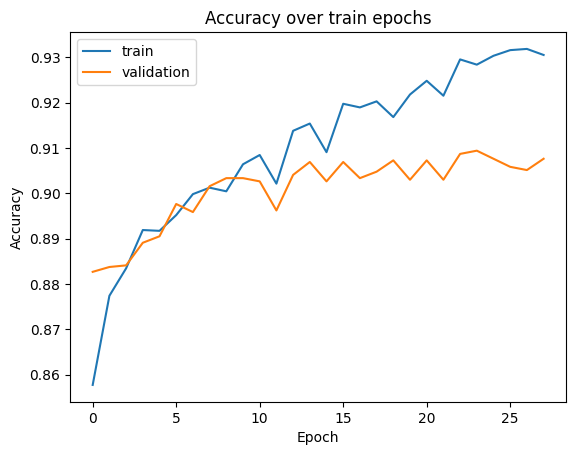

In [39]:
plt.plot(fine_tuning_history.history['accuracy'], label='train')
plt.plot(fine_tuning_history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Obtención de Resultados

Debemos hacer predicciones sobre el conjunto test y generar un archivo .csv

In [37]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Ruta completa donde se guardará el archivo CSV
output_csv_path = Path(BASE_DIR + '/predicciones2.csv')  

test_images = os.listdir(TEST_DIR)

results = []

# Procesamiento en batch para mejorar el rendimiento
batch_size = 32

for i in range(0, len(test_images), batch_size):
    batch_images = test_images[i:i + batch_size]
    batch_data = []

    for img_name in batch_images:
        img_path = os.path.join(TEST_DIR, img_name)
        img = load_img(img_path, target_size=bigger_input_shape[:2])
        img_array = img_to_array(img) / 255.0
        batch_data.append(img_array)

    batch_data = np.array(batch_data)

    # Realizar predicción en batch
    predictions = model.predict(batch_data)

    for j, img_name in enumerate(batch_images):
        predicted_label = CLASES[predictions[j].argmax()]
        results.append([img_name, predicted_label])

# Crear el DataFrame y guardarlo como CSV
df = pd.DataFrame(results, columns=['ID', 'Label'])
df.to_csv(output_csv_path, index=False)

print(f"Archivo CSV generado en: {output_csv_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

In [38]:
df = pd.read_csv(output_csv_path)

print(df)

             ID      Label
0     22875.jpg        sea
1     20498.jpg     street
2     22893.jpg   mountain
3     21479.jpg     street
4     22780.jpg    glacier
...         ...        ...
2995  21505.jpg  buildings
2996  23240.jpg     forest
2997  20304.jpg        sea
2998  23736.jpg   mountain
2999  20668.jpg    glacier

[3000 rows x 2 columns]


# Conclusión

### Preparación de datasets

En este trabajo tomamos un dataset de imágenes y lo usamos para entrenar múltiples modelos de redes neuronales.

Un detalle sobre el conjunto de datos es que contábamos con train y test únicamente, por lo que debimos generar un dataset de validation. Esto lo hicimos seleccionando y extrayendo (no copiando) imágenes al azar del conjunto train.

### Renegada con Cuda
Cabe aclarar que gran parte del tiempo destinado a hacer este notebook y trabajo en general, consistió en hacer andar la GPU (RTX 3060) con tensorflow. La PC utilizada tiene como SO Windows 11, y debimos correr Tensorflow dentro de WSL2, lo que no fue sencillo, pero nos dió mucha ventaja en cuanto a tiempo de entrenamiento posteriormente.

Aparecieron problemas algo graciosos, desde llenar el espacio del disco y esperar eternamente a que se instalen las dependencias de cuda (para luego de 2 horas comprender que era un problema de almacenamiento), hasta compartirnos el dataset a través de un pen-drive (para tener el mismo conjunto validation generado aleatoriamente), y que los archivos se rompan, teniendo algunas imágenes que no podían ser leídas por el kernel.

### Modelos entrenados
Al principio entrenamos un modelo de tipo MLP, demostrando que no tiene utilidad en este tipo de problemas.

Luego pasamos a redes convolucionales, que tienen más sentido para imágenes. Creamos 5 modelos, a los que les suministramos las imágenes sin redimensionar, aprovechando que teníamos potencia de cómputo suficiente para soportarlo. Fuimos probando más y menos capas, más y menos dropout, manteniendo el resto de parámetros relativamente estáticos.
Si bien los resultados eran buenos (mucho mejores que con MLP), aún no era suficiente, más que nada al compararnos con el resto de grupos en la competencia de Kaggle.

Para mejorar esto, decidimos utilizar técnicas avanzadas como transfer-learning, y probamos múltiples modelos pre-entrenados, teniendo mejores resultados con InceptionV2, que es uno de los más exigentes en cuanto a recursos.

Nos quedó pendiente por probar aumentación de datos, que hubiese sido interesante, aunque es cierto que no tuvimos tanto overfitting como para justificarlo.